In [1]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


1 -88.3540267944336


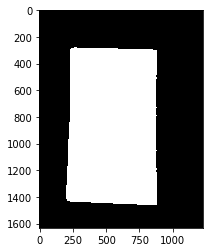

In [2]:
#beolvassuk a képet:
img = cv2.pyrDown(cv2.imread('C:/Users/Base/digit/IMG-0131.jpg'))

#létrehozunk egy szürkeárynalatos képet:
grey = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
#amit elhomályosítunk:
grey = cv2.GaussianBlur(grey, (55, 55), 0)



# threshold
ret, threshed_img = cv2.threshold(grey.copy(),70,255,cv2.THRESH_BINARY)

# kontúrokat keresünk:

contours, hier = cv2.findContours(threshed_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# és a külsőket kijelöljük
for c in contours:

    # a lehető legkisebb területű téglalapot illesztjük rá 
    rect = cv2.minAreaRect(c)
    # ennek dőlésszöge:
    angle = cv2.minAreaRect(c)[-1]
    #ennek pontjainak koordinátái:
    box = cv2.boxPoints(rect)
    # egész számmá konvertáljuk:
    box = np.int0(box)
    
# hány kontúrt vett észre, melyiknek milyen a dőlésszöge:
# ha 1-nél többet, tudjuk, hogy itt a hiba. 
print(len(contours),angle)

# a kontúr ábrázolása:
plt.imshow(threshed_img, cmap="gray")
plt.show()


In [3]:
# a kontúr érzékelt szögének megfelelő irányú forgatás, és mennyisége:
if angle < -45:
    angle = (90 + angle)
 
else:
    angle = angle

In [4]:
# forgatás az eredeti képen:
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h),
    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

[INFO] angle: 1.646


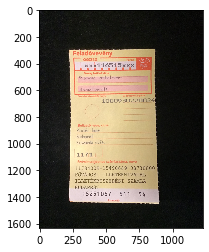

In [5]:

# a forgatás szöge:
print("[INFO] angle: {:.3f}".format(angle))

plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.show()


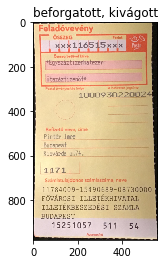

In [6]:
# kivágás

# létrehozunk egy szürkeárynalatos képet:
grey = cv2.cvtColor(rotated.copy(), cv2.COLOR_BGR2GRAY)
# amit elhomályosítunk:
grey = cv2.GaussianBlur(grey, (15, 15), 0)

# threshold
ret, thresh = cv2.threshold(grey.copy(),70,255,cv2.THRESH_BINARY)

# kontúrokat keresünk:
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

# és a legkülsőt kiválasztjuk.
cnt = contours[0]
x,y,w,h = cv2.boundingRect(cnt)

# e mentén kiválasztjuk a nekünk kellő pixeleket:
crop = rotated[y:y+h,x:x+w]



# újraméretezzük a képet, ezáltal uniformizálunk:

width = 560
height = 980
dim = (width, height)
 
# újraméretezés:
crop = cv2.resize(crop, dim, interpolation = cv2.INTER_AREA)

# a kivágott kép ábrázolása:
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.title('beforgatott, kivágott')
plt.show()

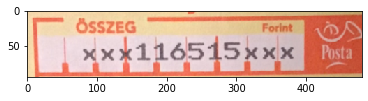

In [7]:
# az összeg beolvasásához szükséges képrészlet kivágása:
cropki = crop[45:140,20:500]
# és ábrázolása:
plt.imshow(cv2.cvtColor(cropki, cv2.COLOR_BGR2RGB))
cv2.imwrite('C:/Users/Base/digit/cella.jpg',cropki);

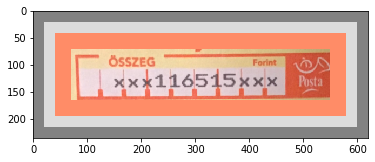

In [8]:
# a képen három domináns szín jeleni meg, a terv, hogy ezekre a színekre bontjuk bontjuk a képet
# k-közép-módszerrel.
# ehhez létrehozunk egy változót:
kk = cropki

# hogy a k-közép "ráharapjon" ezekre a színekre, vastag keretet hozunk létre belőlük:
kk = cv2.copyMakeBorder(kk, 30, 30, 30, 30, cv2.BORDER_CONSTANT,value=[103,140,255])
kk = cv2.copyMakeBorder(kk, 20, 20, 20, 20, cv2.BORDER_CONSTANT,value=[220,220,220])
kk = cv2.copyMakeBorder(kk, 20, 20, 20, 20, cv2.BORDER_CONSTANT,value=[130,130,130])

# ábrázoljuk az így képzett képet:
plt.imshow(cv2.cvtColor(kk, cv2.COLOR_BGR2RGB))

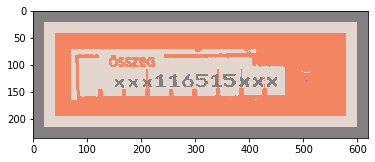

In [9]:
# K-közép alkalmazása:

Z = kk.reshape((-1,3))

# float32 formátumúvá alakítjuk Z-t
Z = np.float32(Z)

# kritérium difiniálása
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# klaszterek száma:
K = 3
#k-közép:
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# visszakonvertáljuk unit8-ba:
center = np.uint8(center)
#létrehozzuk az új képet:
res = center[label.flatten()]
res2 = res.reshape((kk.shape))

# valamint ábrázoljuk azt:
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))

A szürkén kívüli színeket fehérre cseréljük:

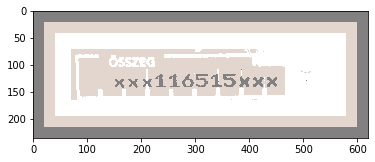

In [10]:
# a pirosat:
ker=[res2[40,40,0],res2[40,40,1],res2[40,40,2]]
for i in range(res2.shape[0]):
    for j in range(res2.shape[1]):
        for l in range(3):
            if res2[i,j,l]==ker[l]:
                res2[i,j,l]=255
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))

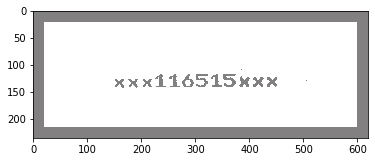

In [11]:
# a papír színét:
hat=[res2[20,20,0],res2[20,20,1],res2[20,20,2]]
for i in range(res2.shape[0]):
    for j in range(res2.shape[1]):
        for l in range(3):
            if res2[i,j,l]==hat[l]:
                res2[i,j,l]=255
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))

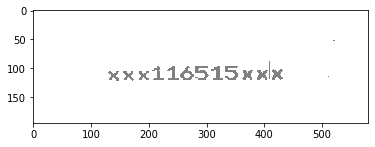

In [12]:
# levágjuk a szürke keretet:

res2 = res2[20:res2.shape[0]-20,20:res2.shape[1]-20]

#átskálázzuk a képet a kényelmes kezelés érdekében:
scale_percent = 200 # <- a nagyítás mértéke százalékban
width = int(res2.shape[1] * scale_percent / 100)
height = int(res2.shape[0] * scale_percent / 100)
dim = (width, height)
# a kép újraméretezése
resized = cv2.resize(res2, dim, interpolation = cv2.INTER_AREA)

# kiírjuk fileba, és ábrázoljuk:
cv2.imwrite('C:/Users/Base/digit/cella.jpg',resized)
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))

In [13]:
# betöltjük az elmentett hálózatot:
model = load_model('C:/Users/Base/digit/modelll.h5')




----------------Szűrt kép--------------------


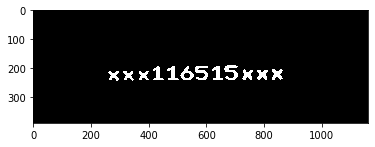




----------------Detektált objektumok--------------------


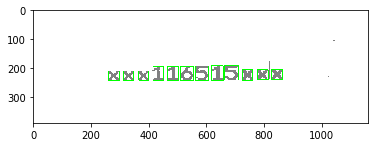

In [14]:
# betöltjük a tisztázott képet:
image = cv2.imread("C:/Users/Base/digit/cella.jpg")
# létrehozunk egy szürkeárynalatos képet:
grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
# amit elhomályosítunk a hibák elkenése érdekében:
grey = cv2.GaussianBlur(grey, (15, 15), 0)

# threshold
ret, thresh = cv2.threshold(grey.copy(),200,255,cv2.THRESH_BINARY_INV)

# kontúrokat keresünk:
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# létrehozunk egy változót, amiben a felismerendő alakzatokat (kontúrokat) fogjuk elhelyezni:
preprocessed_digits = []

for c in contours:
    
    x,y,w,h = cv2.boundingRect(c)
    
    # létre hozunk egy téglalapot a kontúr körül, amit az eredeti képre rajzolunk:
    cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)
    
    # kivágjuk az aktuális (c-edik) kontúrt:
    digit = thresh[y:y+h, x:x+w]
    
    # átskálázzuk a képet 18 x 18-asra
    resized_digit = cv2.resize(digit, (18,18))
    
    # ki pad-deljük a képet 5 fekete pixellel minden oldalon, így megkapjuk a 28 x 28-as bemenetet
    padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)
    
    # hozzáadjuk a számjegyet a preprocesszált szájegyek listájához:
    preprocessed_digits.append(padded_digit)

print("\n\n\n----------------Szűrt kép--------------------")
plt.imshow(thresh, cmap="gray")
plt.show()
print("\n\n\n----------------Detektált objektumok--------------------")
plt.imshow(image, cmap="gray")
plt.show()



---------------------------------------


=========PREDICTION============ 




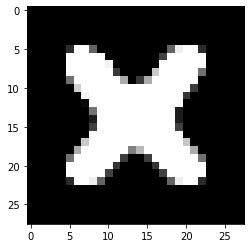



Final Output: 4

Prediction (Softmax) from the neural network:

 [[7.4541172e-11 7.4400705e-05 2.5720390e-02 9.3860933e-08 9.6213114e-01
  3.8343290e-11 8.8279058e-11 1.1865002e-10 1.2073992e-02 6.8771465e-15]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




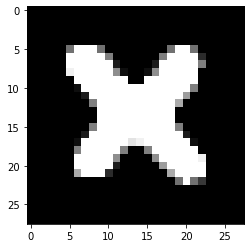



Final Output: 1

Prediction (Softmax) from the neural network:

 [[5.5589626e-13 5.7997018e-01 1.3992526e-01 8.7571661e-06 2.7886105e-01
  4.3316316e-08 5.3387021e-07 1.9725761e-08 1.2342102e-03 3.4811656e-13]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




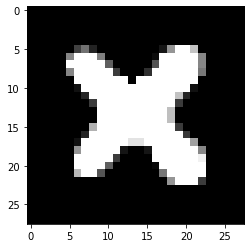



Final Output: 1

Prediction (Softmax) from the neural network:

 [[3.96657100e-12 6.77706778e-01 1.76884849e-02 3.31487186e-04
  2.01014280e-01 7.16213266e-09 1.01424504e-07 4.86492721e-11
  1.03258863e-01 6.28870437e-13]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




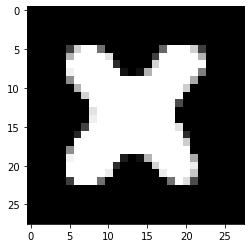



Final Output: 2

Prediction (Softmax) from the neural network:

 [[3.2405520e-10 7.4980856e-04 9.6003926e-01 4.7568165e-06 2.3406656e-02
  9.5242800e-09 4.4721724e-09 1.0049782e-09 1.5799474e-02 4.2931814e-10]]


Hard-maxed form of the prediction: 

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




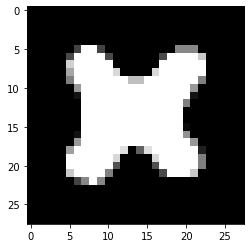



Final Output: 4

Prediction (Softmax) from the neural network:

 [[5.2752686e-10 1.6774733e-05 9.4796963e-02 8.6704816e-10 9.0517557e-01
  1.8963232e-07 3.1975592e-08 9.1115657e-09 1.0415718e-05 1.0550853e-11]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




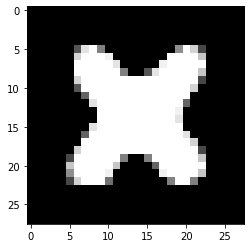



Final Output: 2

Prediction (Softmax) from the neural network:

 [[4.3288931e-10 9.0535288e-04 8.8932019e-01 1.2832817e-07 8.5737050e-02
  3.3858529e-09 9.3105989e-08 9.7427222e-10 2.4037179e-02 3.9738234e-11]]


Hard-maxed form of the prediction: 

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




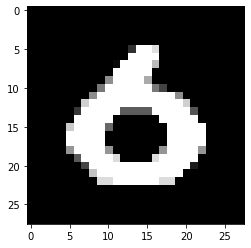



Final Output: 0

Prediction (Softmax) from the neural network:

 [[9.9072659e-01 1.4222471e-12 6.7496331e-10 4.4022418e-05 7.9721019e-10
  4.8775872e-04 8.7390747e-03 2.0367842e-13 3.1013274e-09 2.5333177e-06]]


Hard-maxed form of the prediction: 

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




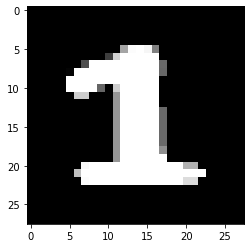



Final Output: 2

Prediction (Softmax) from the neural network:

 [[6.21716723e-08 1.55683467e-02 9.84214962e-01 2.16606903e-04
  3.62013110e-12 3.86729830e-08 1.80580247e-12 1.43864426e-11
  1.73566974e-08 1.62339489e-16]]


Hard-maxed form of the prediction: 

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




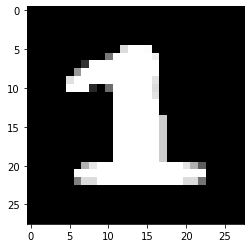



Final Output: 2

Prediction (Softmax) from the neural network:

 [[1.2016481e-04 2.9524505e-01 4.3130770e-01 2.7332339e-01 2.7140076e-10
  3.5767502e-09 9.8541401e-13 1.0929558e-11 3.5999847e-06 4.8943254e-12]]


Hard-maxed form of the prediction: 

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




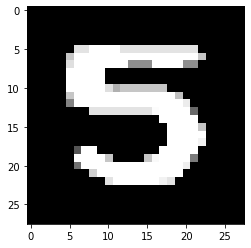



Final Output: 5

Prediction (Softmax) from the neural network:

 [[1.0956555e-18 6.3742776e-25 1.0360961e-18 1.5734370e-11 1.8281766e-19
  1.0000000e+00 1.4806726e-18 1.4462254e-16 6.4517911e-21 3.0441424e-17]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




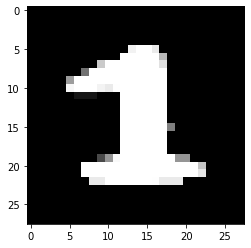



Final Output: 2

Prediction (Softmax) from the neural network:

 [[4.1358571e-06 1.0183746e-03 9.5948547e-01 3.9485428e-02 1.1822434e-07
  2.8471734e-07 1.7837403e-13 6.1284054e-06 1.2082228e-08 1.2874979e-13]]


Hard-maxed form of the prediction: 

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




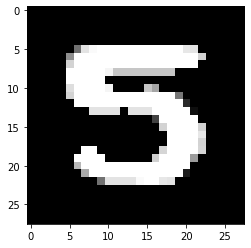



Final Output: 5

Prediction (Softmax) from the neural network:

 [[6.7547385e-22 7.4106131e-25 6.1793497e-22 3.4282408e-09 3.0624908e-22
  1.0000000e+00 1.7466405e-21 3.8848846e-16 3.0113824e-20 1.5607783e-19]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


---------------------------------------




In [15]:
# tömbbé alakítjuk:
inp = np.array(preprocessed_digits)

# minden detektált kontúrra becslést kérünk a hálózattól, és ábrázoljuk azokat:
for digit in preprocessed_digits:
    
    prediction = model.predict(digit.reshape(1, 28, 28, 1))
    
    print ("\n\n---------------------------------------\n\n")
    print ("=========PREDICTION============ \n\n")
    
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.show()
    
    print("\n\nFinal Output: {}".format(np.argmax(prediction)))
    print ("\nPrediction (Softmax) from the neural network:\n\n {}".format(prediction))
    hard_maxed_prediction = np.zeros(prediction.shape)
    hard_maxed_prediction[0][np.argmax(prediction)] = 1
    print ("\n\nHard-maxed form of the prediction: \n\n {}".format(hard_maxed_prediction))
    print ("\n\n---------------------------------------\n\n")